# An Introduction to Football Player Dashboards Using Python and Matplotlib

From the blog [post](https://medium.com/geekculture/an-introduction-to-football-player-dashboards-using-python-and-matplotlib-eb5328dfe85f) at Medium

Link to original jupyter notebook: [GitHub](https://github.com/shreyas7kha/DataVizTutorial/blob/main/DataVizProj.ipynb)

### Jack Grealish's Goals

In [20]:
# Imports
import requests
from bs4 import BeautifulSoup as soup
from bs4 import Comment
import json
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import mplsoccer
from mplsoccer import VerticalPitch
from highlight_text import HighlightText, ax_text, fig_text

### Scraping from Understat

In [2]:
# Jack Grealish's PLAYER ID IN UNDERSTAT IS 675
url = 'https://understat.com/player/675'
html = requests.get(url)
parse_soup = soup(html.content, 'lxml')

In [3]:
scripts = parse_soup.find_all('script')
shots_data_script = scripts[3].string

ind_start = shots_data_script.index("('")+2
ind_end = shots_data_script.index("')")

shots_data_json = shots_data_script[ind_start:ind_end]
shots_data_json = shots_data_json.encode('utf8').decode('unicode_escape')

In [4]:
data = json.loads(shots_data_json)

In [5]:
x = []
y = []
xg = []
result = []
season = []

In [6]:
for i in range(len(data)):
    for key in data[i]:
        if key=='X':
            x.append(data[i][key])
        if key=='Y':
            y.append(data[i][key])
        if key=='xG':
            xg.append(data[i][key])
        if key=='result':
            result.append(data[i][key])
        if key=='season':
            season.append(data[i][key])

columns = ['X','Y','xG','Result','Season']
df_understat = pd.DataFrame([x, y, xg, result, season], index=columns)
df_understat = df_understat.T
df_understat = df_understat.apply(pd.to_numeric,errors='ignore')

In [7]:
df_understat

,X,Y,xG,Result,Season
0,0.848,0.641,0.056389,SavedShot,2014
1,0.848,0.482,0.103194,BlockedShot,2014
2,0.848,0.718,0.031848,MissedShots,2014
3,0.878,0.579,0.063040,SavedShot,2014
4,0.809,0.702,0.025430,BlockedShot,2014
...,...,...,...,...,...
152,0.854,0.688,0.040807,BlockedShot,2021
153,0.862,0.375,0.078635,BlockedShot,2021
154,0.910,0.670,0.102757,SavedShot,2021
155,0.955,0.534,0.598878,Goal,2021


In [8]:
df_understat['X'] = df_understat['X'].apply(lambda x:x*100)
df_understat['Y'] = df_understat['Y'].apply(lambda x:x*100)

In [9]:
df_understat

,X,Y,xG,Result,Season
0,84.800003,64.099998,0.056389,SavedShot,2014
1,84.800003,48.200001,0.103194,BlockedShot,2014
2,84.800003,71.800003,0.031848,MissedShots,2014
3,87.800003,57.900002,0.063040,SavedShot,2014
4,80.900002,70.199997,0.025430,BlockedShot,2014
...,...,...,...,...,...
152,85.400002,68.800003,0.040807,BlockedShot,2021
153,86.199997,37.500000,0.078635,BlockedShot,2021
154,91.000000,67.000000,0.102757,SavedShot,2021
155,95.500000,53.400002,0.598878,Goal,2021


### Scraping from Fbref

In [10]:
def readfromfbrefhtmlforRPL(url):
    fbref_html = requests.get(url)
    fbref_soup = soup(fbref_html.content, 'lxml')
    comments = fbref_soup.find_all(text=lambda text:isinstance(text, Comment))
    # Таблица со статистикой ударов изначально закомментирована по какой-то причине
    fbref_df = pd.read_html(comments[23])[0]
    
    column_lst = list(fbref_df.columns)
    for index in range(len(column_lst)):
        column_lst[index] = column_lst[index][1]
    
    fbref_df.columns = column_lst
    fbref_df.drop(fbref_df[fbref_df['Player'] == 'Player'].index, inplace=True)
    fbref_df = fbref_df.fillna('0')
    fbref_df.set_index('Rk', drop=True, inplace=True)
    try:
        fbref_df['Nation'] = fbref_df['Nation'].astype(str)
        fbref_df['Nation'] = fbref_df['Nation'].apply(lambda x: x.split()[-1])
    except:
        print('Error in parsing table in url:' + url)
    finally:
        fbref_df = fbref_df.apply(pd.to_numeric, errors='ignore')
    return fbref_df

In [11]:
df_fbref_rus = readfromfbrefhtmlforRPL('https://fbref.com/en/comps/30/shooting/Russian-Premier-League-Stats')
df_fbref_rus

,Player,Nation,Pos,Squad,Age,Born,90s,Gls,Sh,SoT,SoT%,Sh/90,SoT/90,G/Sh,G/SoT,Dist,PK,PKatt,Matches
Rk,,,,,,,,,,,,,,,,,,,
1,Oliver Abildgaard,DEN,MF,Rubin Kazan,25-089,1996,5.0,0,5,2,40.0,1.00,0.40,0.00,0.0,0,0,0,Matches
2,Arsen Adamov,RUS,DF,Ural,21-322,1999,6.0,0,2,0,0.0,0.33,0.00,0.00,0.0,0,0,0,Matches
3,Kemal Ademi,SUI,FW,FC Khimki,25-227,1996,1.9,0,5,2,40.0,2.57,1.03,0.00,0.0,0,0,0,Matches
4,Gamid Agalarov,RUS,FW,Ufa,21-053,2000,4.2,5,14,8,57.1,3.33,1.90,0.29,0.5,0,1,1,Matches
5,Mikhail Ageev,RUS,FW,Ural,21-138,2000,2.6,0,5,1,20.0,1.93,0.39,0.00,0.0,0,0,0,Matches
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
337,Yuri Zhuravlyov,RUS,DF,Ufa,25-070,1996,6.0,0,4,1,25.0,0.67,0.17,0.00,0.0,0,0,0,Matches
338,Anton Zinkovskiy,RUS,MF,Samara,25-146,1996,5.4,0,15,1,6.7,2.80,0.19,0.00,0.0,0,0,0,Matches
339,Roman Zobnin,RUS,MF,Spartak Moscow,27-208,1994,5.2,2,13,4,30.8,2.49,0.77,0.15,0.5,0,0,0,Matches


In [12]:
def readfromhtml(filepath):
    df = pd.read_html(filepath)[0]
    column_lst = list(df.columns)
    for index in range(len(column_lst)):
        column_lst[index] = column_lst[index][1]
    df.columns = column_lst
    df.drop(df[df['Player'] == 'Player'].index, inplace=True)
    df = df.fillna('0')
    df.set_index('Rk', drop=True, inplace=True)
    try:
        df['Comp'] = df['Comp'].apply(lambda x: ' '.join(x.split()[1:]))
        df['Nation'] = df['Nation'].astype(str)
        df['Nation'] = df['Nation'].apply(lambda x: x.split()[-1])
    except:
        print('Error in uploading file:' + filepath)
    finally:
        df = df.apply(pd.to_numeric, errors='ignore')
    return df

In [13]:
df_fbref_19_20 = readfromhtml('https://fbref.com/en/comps/Big5/2019-2020/shooting/players/2019-2020-Big-5-European-Leagues-Stats')
df_fbref = readfromhtml('https://fbref.com/en/comps/Big5/2020-2021/shooting/players/2020-2021-Big-5-European-Leagues-Stats')
df_fbref

,Player,Nation,Pos,Squad,Comp,Age,Born,90s,Gls,Sh,...,Dist,FK,PK,PKatt,xG,npxG,npxG/Sh,G-xG,np:G-xG,Matches
Rk,,,,,,,,,,,,,,,,,,,,,
1,Ismael Aaneba,FRA,"FW,DF",Strasbourg,Ligue 1,21,1999,0.1,0,0,...,0.0,0,0,0,0.0,0.0,0.00,0.0,0.0,Matches
2,Patrick van Aanholt,NED,DF,Crystal Palace,Premier League,29,1990,19.7,0,18,...,20.3,3,0,0,1.2,1.2,0.07,-1.2,-1.2,Matches
3,Issah Abbas,GHA,"DF,FW",Mainz 05,Bundesliga,21,1998,0.2,0,0,...,0.0,0,0,0,0.0,0.0,0.00,0.0,0.0,Matches
4,Yunis Abdelhamid,MAR,DF,Reims,Ligue 1,32,1987,32.1,3,15,...,10.2,0,0,0,1.7,1.7,0.11,1.3,1.3,Matches
5,Sabit Abdulai,GHA,MF,Getafe,La Liga,21,1999,0.7,0,0,...,0.0,0,0,0,0.0,0.0,0.00,0.0,0.0,Matches
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2818,Steven Zuber,SUI,"DF,MF",Eint Frankfurt,Bundesliga,28,1991,6.5,0,10,...,18.2,0,0,0,0.8,0.8,0.08,-0.8,-0.8,Matches
2819,Martín Zubimendi,ESP,MF,Real Sociedad,La Liga,21,1999,20.9,0,7,...,12.3,0,0,0,0.6,0.6,0.08,-0.6,-0.6,Matches
2820,Martin Ødegaard,NOR,MF,Arsenal,Premier League,21,1998,9.6,1,15,...,20.5,1,0,0,1.1,1.1,0.07,-0.1,-0.1,Matches


### Drawing plots

In [17]:
background = '#D6DBD9'
text_color = 'black'
mpl.rcParams['xtick.color']=text_color
mpl.rcParams['ytick.color']=text_color
mpl.rcParams['text.color']=text_color
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['legend.fontsize'] = 15

#### Step 1. Drawing background

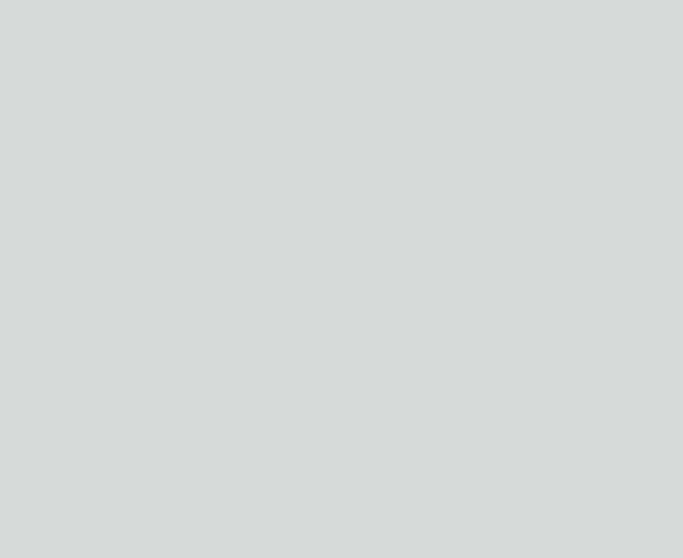

In [18]:
# SETTING UP THE AXES
fig, ax = plt.subplots(figsize=(12,10))
ax.axis('off')
fig.set_facecolor(background)

#### Step 2. Drawing Opta pitch for first season

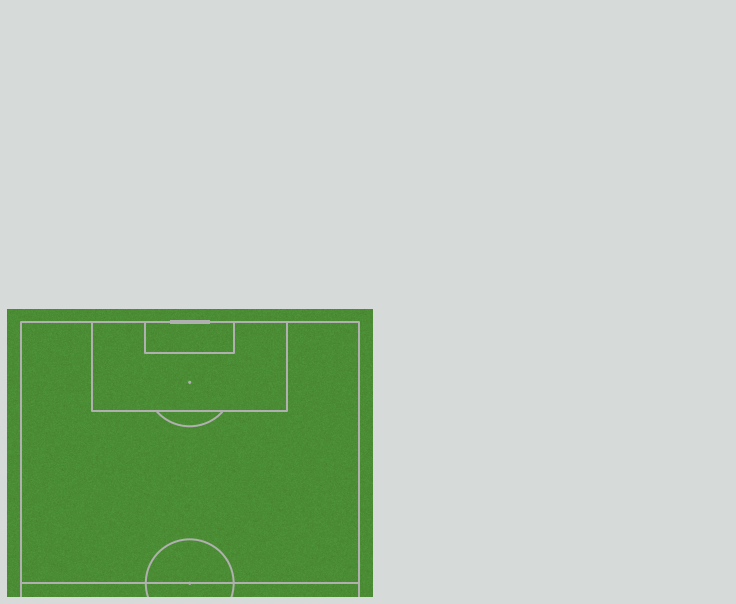

In [22]:
#SETTING UP THE MPL AXIS FOR THE FIRST SEASON
pitch = mplsoccer.VerticalPitch(half=True, pitch_type='opta', pitch_color='grass')
ax_opta1 = fig.add_axes((0.05, 0.06, 0.45, 0.4))
ax_opta1.patch.set_facecolor(background)
pitch.draw(ax=ax_opta1)
fig

#### Step 3. Plot shots that are not goals

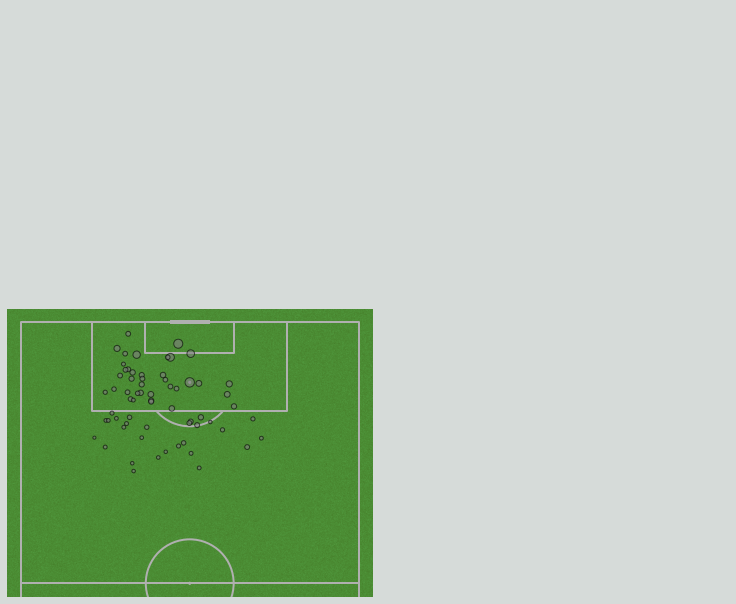

In [23]:
df_fil = df_understat.loc[df_understat['Season']==2019]
#PLOTTING NOT GOAL SHOTS
pitch.scatter(
    df_fil[df_fil['Result']!='Goal']['X'],
    df_fil[df_fil['Result']!='Goal']['Y'], 
    s=np.sqrt(df_fil[df_fil['Result']!='Goal']['xG'])*100, 
    marker='o', 
    alpha=0.6,
    edgecolor='black', 
    facecolor='grey', 
    ax=ax_opta1
)
fig

#### Step 4. Plot the goals

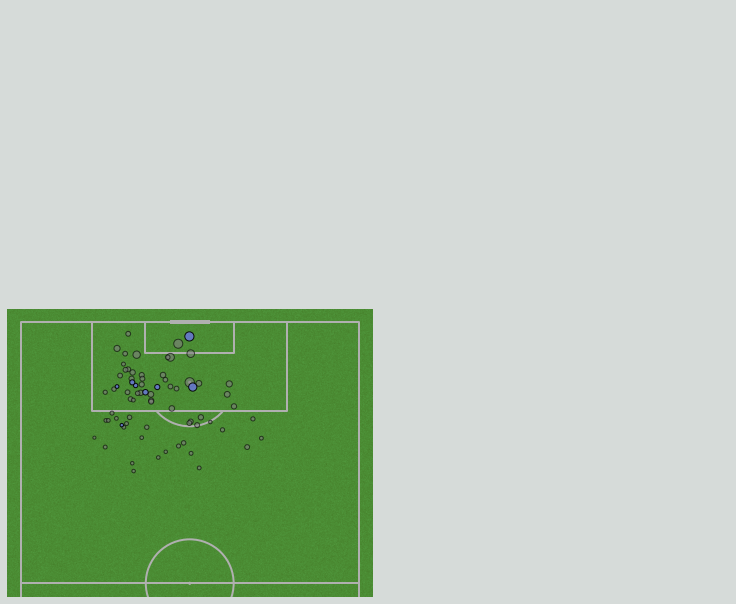

In [24]:
# NOW PLOTTING THE GOALS IN THE 2019-20 SEASON
pitch.scatter(
    df_fil[df_fil['Result']=='Goal']['X'],
    df_fil[df_fil['Result']=='Goal']['Y'], 
    s=np.sqrt(df_fil[df_fil['Result']=='Goal']['xG'])*100, 
    marker='o', 
    alpha=0.9,
    edgecolor='black', 
    facecolor='#6778d0', 
    ax=ax_opta1, 
    label='Goal'
)
fig

#### Step 5. Adding the label

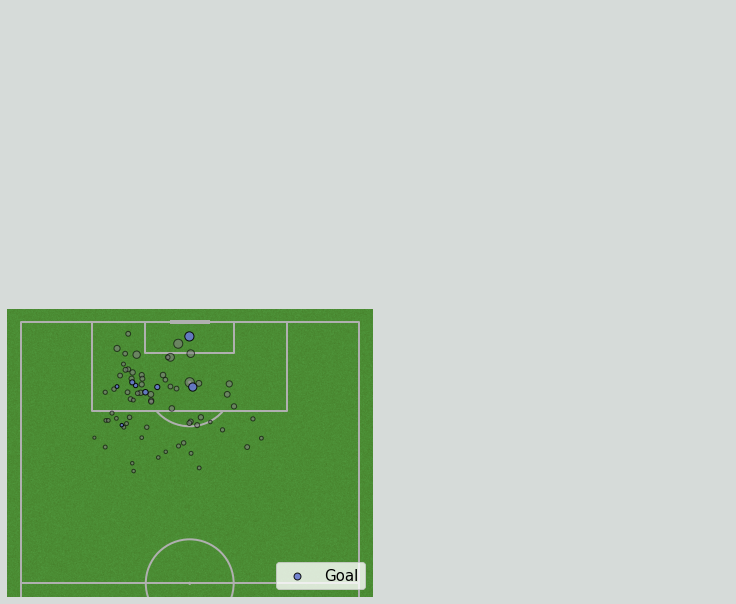

In [25]:
# ADDING THE LEGEND
ax_opta1.legend(loc='lower right').get_texts()[0].set_color("black")
fig

#### Step 6. Additional information

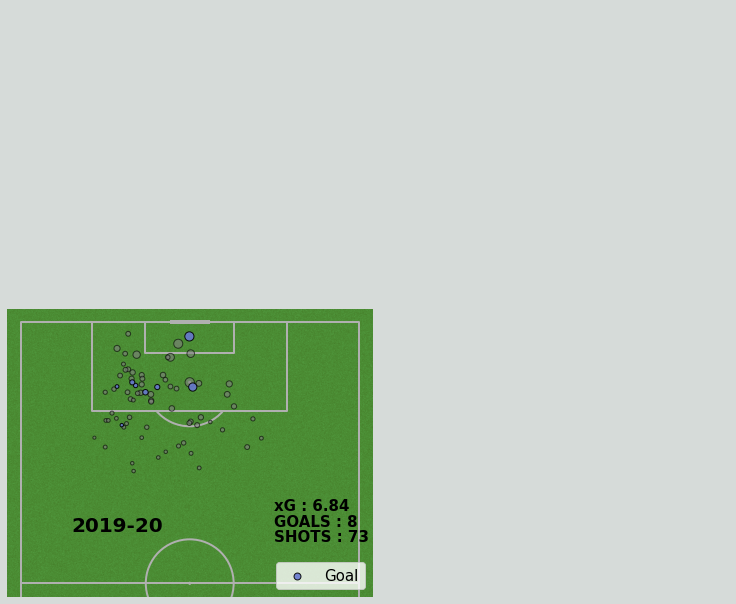

In [26]:
ax_opta1.text(25, 61, 'GOALS : '+str(len(df_fil[df_fil['Result']=='Goal'])), weight='bold', size=15)
ax_opta1.text(25, 64, f"xG : {round(sum(df_fil['xG']),2)}", weight='bold', size=15)
ax_opta1.text(25, 58, 'SHOTS : '+str(len(df_fil)), weight='bold', size=15)
ax_opta1.text(85, 60, '2019-20', weight='bold', size=20)
fig

#### Step 7. Repeat for season 20-21

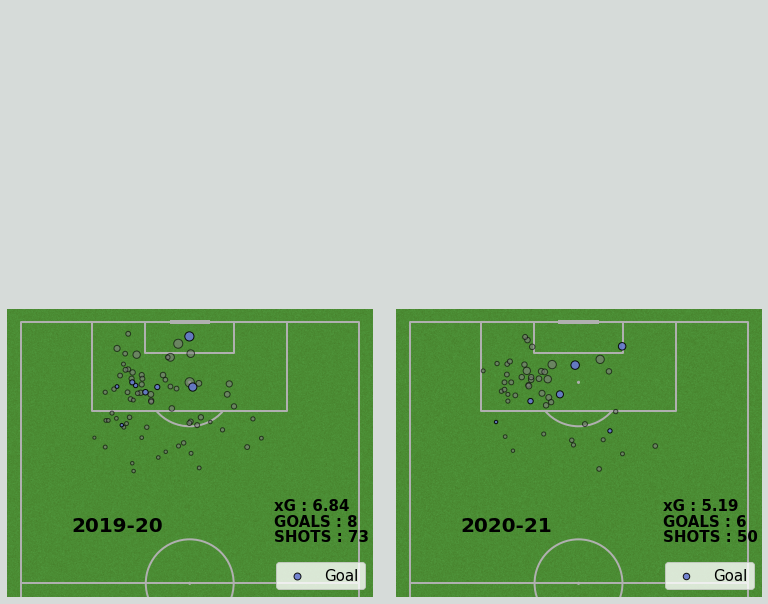

In [27]:
# DOING THE SAME FOR THE 20-21 SEASON TOO
ax_opta2 = fig.add_axes((0.50, 0.06, 0.45, 0.4))
ax_opta2.patch.set_facecolor(background)
pitch.draw(ax=ax_opta2)

#PLOTTING OTHER SHOTS
df_fil = df_understat.loc[df_understat['Season'] == 2020]
pitch.scatter(
    df_fil[df_fil['Result']!='Goal']['X'],
    df_fil[df_fil['Result']!='Goal']['Y'], 
    s=np.sqrt(df_fil[df_fil['Result']!='Goal']['xG'])*100, 
    marker='o', 
    alpha=0.6,
    edgecolor='black', 
    facecolor='grey', 
    ax=ax_opta2
)

#NOW PLOTTING THE GOALS IN THE 2020-21 SEASON
pitch.scatter(
    df_fil[df_fil['Result']=='Goal']['X'],
    df_fil[df_fil['Result']=='Goal']['Y'], 
    s=np.sqrt(df_fil[df_fil['Result']=='Goal']['xG'])*100, 
    marker='o', 
    alpha=0.9,
    edgecolor='black', 
    facecolor='#6778d0', 
    ax=ax_opta2, 
    label='Goal'
)

# ADDING THE LEGEND
ax_opta2.legend(loc='lower right').get_texts()[0].set_color("black")
ax_opta2.text(25,61,'GOALS : '+str(len(df_fil[df_fil['Result']=='Goal'])), weight='bold', size=15)
ax_opta2.text(25,64,f"xG : {round(sum(df_fil['xG']),2)}", weight='bold', size=15)
ax_opta2.text(25,58,'SHOTS : '+str(len(df_fil)), weight='bold', size=15)
ax_opta2.text(85, 60, '2020-21', weight='bold', size=20)

fig

#### Step 9. Scatterplot

In [28]:
# NOW PLOTTING THE SCATTERPLOT
ax_scatter = fig.add_axes([0.52,0.57,0.4,0.35])
ax_scatter.patch.set_facecolor(background)

#### Step 10. Plot the goals vs expected goals

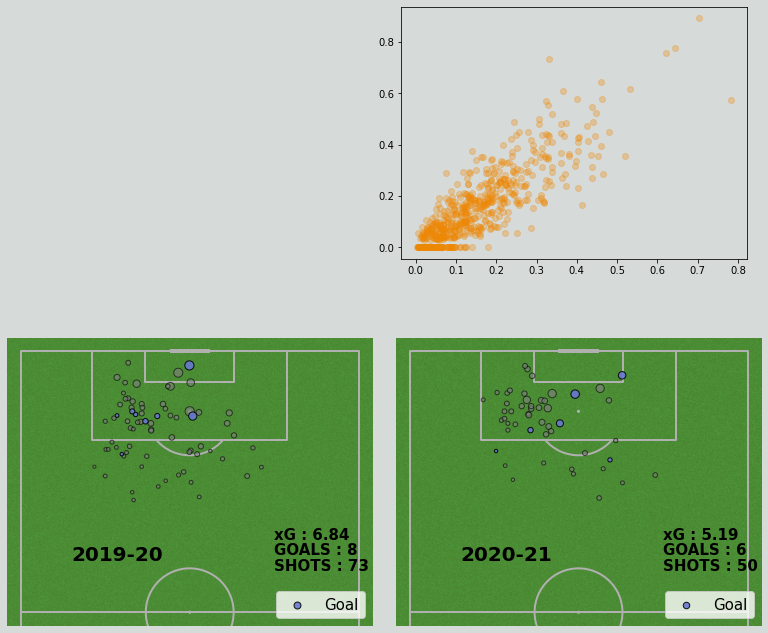

In [29]:
# SETTING UP THE X AND Y OF THE SCATTERPLOT
no_90s = 10
df_fil = df_fbref[df_fbref['90s'] >= no_90s]
df_fil = df_fil[df_fil['Pos'].apply(lambda x: x in ['MF','MF,FW','FW,MF'])]
x, y = (df_fil['xG']/df_fil['90s']).to_list(), (df_fil['Gls']/df_fil['90s']).to_list()
ax_scatter.scatter(x, y, alpha=0.3, c='#EF8804')
fig

#### Step 11. Filter the data for Jack Grealish

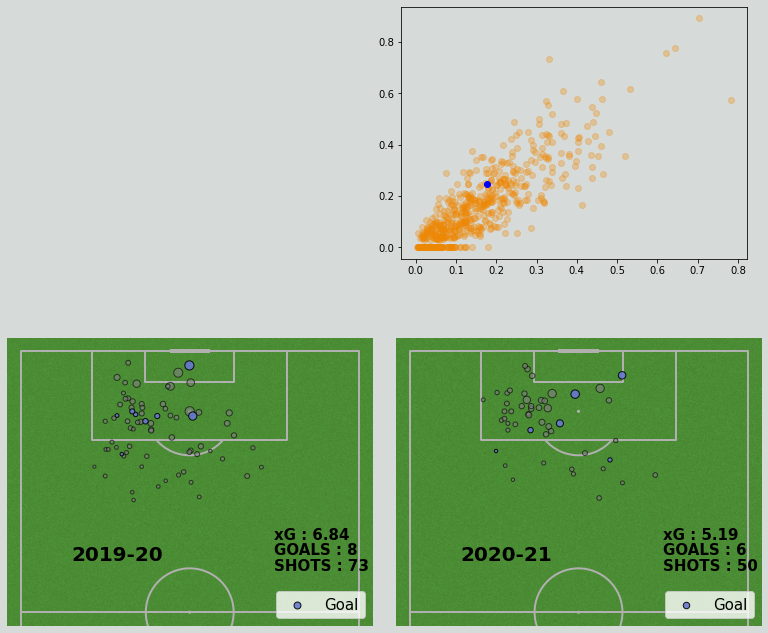

In [30]:
df_player = df_fil[df_fil['Player']=='Jack Grealish']
ax_scatter.scatter(
    df_player['xG']/df_player['90s'], 
    df_player['Gls']/df_player['90s'], 
    c='blue'
)
fig

#### Step 12. Finishing touches

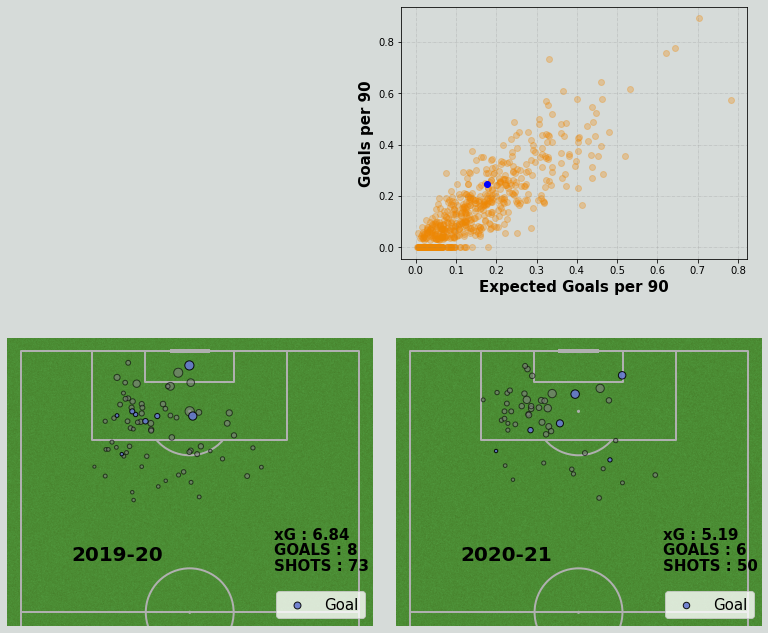

In [31]:
# ADDING FINISHING TOUCHES TO THE SCATTERPLOT
ax_scatter.grid(
    b = True, 
    color ='grey',
    linestyle = '-.', 
    linewidth = 0.5,
    alpha = 0.4
)
ax_scatter.set_xlabel('Expected Goals per 90', fontdict = {'fontsize': 15, 'weight': 'bold', 'color': text_color})
ax_scatter.set_ylabel('Goals per 90', fontdict = dict(fontsize = 15, weight = 'bold', color = text_color))
fig

#### Step 13. Photo, logo and other beauty

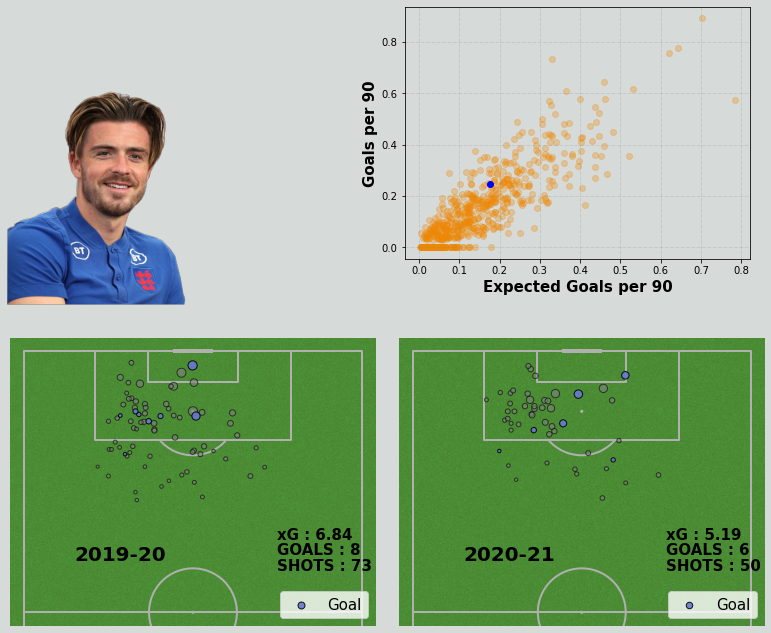

In [32]:
#ADDING GREALISH'S IMAGE
ax_player = fig.add_axes([0.06,0.43,0.25,0.45])
ax_player.axis('off')
im = plt.imread('grealish.png')
ax_player.imshow(im)
fig

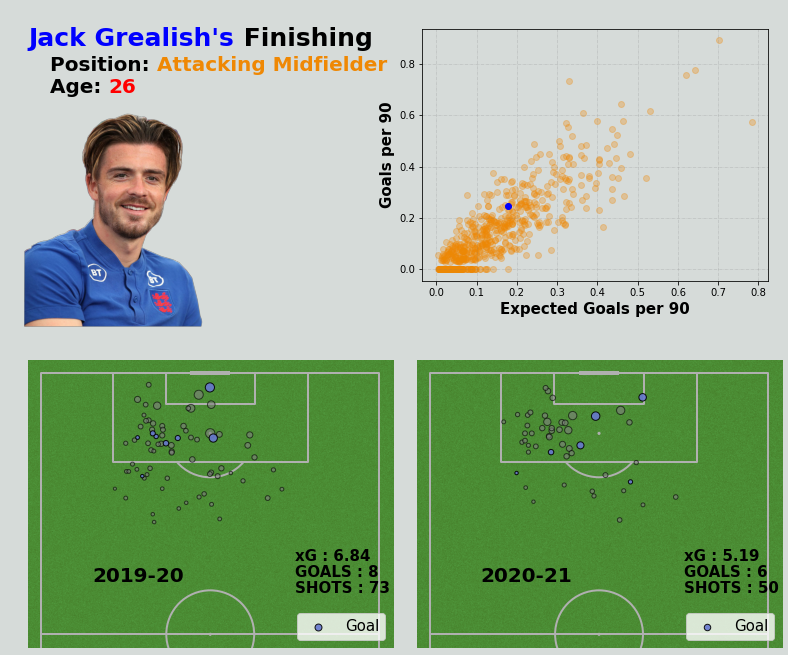

<Figure size 432x288 with 0 Axes>

In [33]:
# ADDING TITLES AND INFO
ax_text = fig.add_axes([0.04,0.50,0.25,0.45])
ax_text.axis('off')
HighlightText(
    x=0.1, y=0.94, s="<Jack Grealish's> Finishing", 
    weight='heavy', size=25, highlight_textprops=[{'color':'blue'}],
    ax=ax_text
)
HighlightText(
    x=0.2, y=0.85, s='Position: <Attacking Midfielder>', 
    weight='bold', size=20, highlight_textprops=[{'color':'#EF8804'}],
    ax=ax_text
)
HighlightText(
    x=0.2, y=0.78, s='Age: <26>', 
    weight='bold', size=20, highlight_textprops=[{'color':'red'}],
    ax=ax_text
)
fig

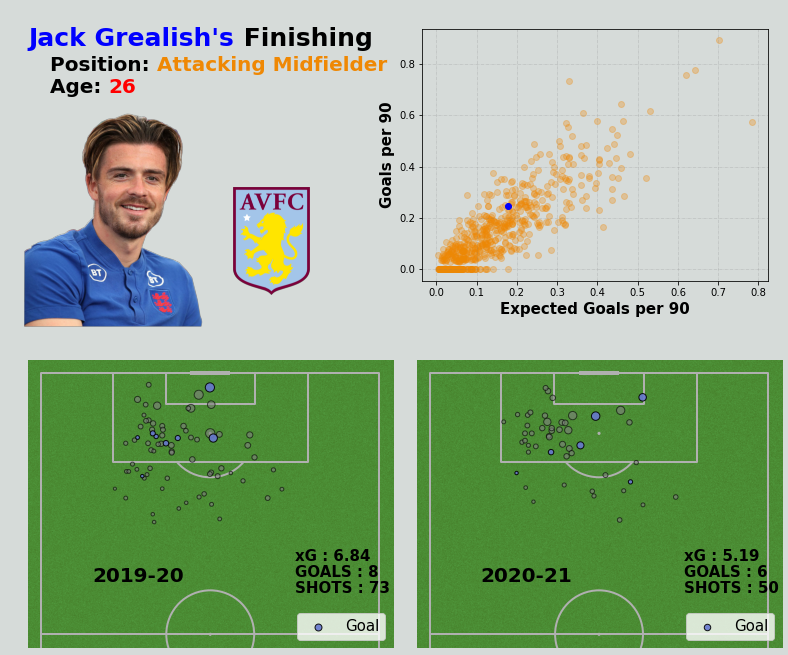

In [34]:
# ADDING CLUB LOGO
ax_team = fig.add_axes([0.27,0.55,0.15,0.15])
ax_team.axis('off')
im = plt.imread('aston_villa.png')
ax_team.imshow(im)
fig

In [36]:
fig.savefig('grealish_dashboard.png')